# **Modelos MLPRegressor**

## Predicción de la volatilidad histórica

* Inputs: Lags del histórico de retornos logarítmicos del precio de Bitcoin.
* Output: la volatilidad futura de 7 días

## Modelado

In [2]:
#   IMPORTS 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsxv.splitTrainValTest import split_train_val_test_groupKFold
import time
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 16,         
    'axes.titleweight': 'bold',   
    'font.family': 'Tahoma', 
})
import joblib
import os

In [3]:
# Configuraciones iniciales 
btc = pd.read_csv(r"C:\Users\Hp\MACHINE\MINI_PRY_2\data\BTC_all.csv") 
WINDOW_SIZES = [7, 14, 21, 28]
colores_por_ventana = { 7: '#377D71',14: '#FBC5C5', 21: '#FBA1A1', 28: '#8879B0'}


In [4]:
# Calcular métricas
def compute_metrics(y_true, y_pred):
    metrics = {"Horizon": [], "MAE": [], "MSE": [], "RMSE": []}
    residuos_dict = {}

    for h in range(7):
        y_t = y_true[:, h]
        y_p = y_pred[:, h]
        resid = y_t - y_p

        mae = mean_absolute_error(y_t, y_p)
        mse = mean_squared_error(y_t, y_p)
        rmse = np.sqrt(mse)

        metrics["Horizon"].append(h+1)
        metrics["MAE"].append(mae)
        metrics["RMSE"].append(rmse)
        metrics["MSE"].append(mse)

        residuos_dict[f"h{h+1}"] = resid

    # Agregados (avg)
    metrics["Horizon"].append("avg")
    metrics["MAE"].append(np.mean(metrics["MAE"]))
    metrics["RMSE"].append(np.mean(metrics["RMSE"]))
    metrics["MSE"].append(np.mean(metrics["MSE"]))

    # Residuales globales
    residuos_dict["all"] = y_true - y_pred

    return pd.DataFrame(metrics), residuos_dict

In [5]:
# Pipeline principal
def main_pipeline(btc, objetivo):
    print(f"=========== Procesando {objetivo} =========== ")
    results = {}

    # Iterar por ventana
    for window_size in WINDOW_SIZES:
        print(f"\n{'='*60}")
        print(f"=== Procesando ventana de {window_size} días === \n Se usa un lag de {window_size} días")

        # Parámetros
        timeSeries = btc[f'Volatil_D{window_size}']
        numInputs = window_size # Máximo de lags a usar (28 días)
        numOutputs = 7 # Días en el horizonte
        numJumps = 1 # Salto de WINDOW_SIZES (1 día)
        print(f"Parámetros: numInputs={numInputs}, numOutputs={numOutputs}, numJumps={numJumps}")
        
        # Split
        X_t, Y_t, X_v, Y_v, X_st, Y_st = split_train_val_test_groupKFold(timeSeries, numInputs, numOutputs, numJumps)
        print(f" Numero de folds generados", len(X_t))
               
        fold_results = []
        start = time.time()
        # Iterar por cada fold
        for fold in range (len(X_t)):
            
            # Dividir datos
            X_train, X_val, X_test = X_t[fold], X_v[fold], X_st[fold]
            Y_train, Y_val, Y_test = Y_t[fold], Y_v[fold], Y_st[fold]

            # Escalar
            X_Scaler = StandardScaler()
            Y_Scaler = StandardScaler()

            X_train_S = X_Scaler.fit_transform(X_train)
            X_val_S = X_Scaler.transform(X_val)
            X_test_S = X_Scaler.transform(X_test)
            Y_train_S = Y_Scaler.fit_transform(Y_train)

            # Modelo
            model = MLPRegressor(
                hidden_layer_sizes=(100, 50),
                activation='relu',
                solver='adam',
                alpha=0.0001,
                learning_rate='constant',
                max_iter=1000,
                early_stopping=True,
                validation_fraction=0.1,
                random_state=42
                )
            # Modelar
            model.fit(X_train_S, Y_train_S)
            # Guardar modelo entrenado
            joblib.dump(model, f"models/{objetivo}__{window_size}d_fold{fold}.pkl")

            # Predicciones
            y_train_pred_S = model.predict(X_train_S)
            y_val_pred_S = model.predict(X_val_S)
            y_test_pred_S = model.predict(X_test_S)

            # Revertir escala
            y_train_pred = Y_Scaler.inverse_transform(y_train_pred_S)
            y_val_pred = Y_Scaler.inverse_transform(y_val_pred_S)
            y_test_pred = Y_Scaler.inverse_transform(y_test_pred_S)

            # Métricas en test por horizonte
            df_metrics, residuos = compute_metrics(Y_test, y_test_pred)
            df_metrics["fold"] = fold
            df_metrics["window"] = window_size

            avg_RMSE = df_metrics.loc[df_metrics["Horizon"]=="avg", "RMSE"].values[0]
            
            # Guardar resultados del fold
            fold_results.append({
                'fold': fold,
                'model': model,
                'metrics_df': df_metrics,
                'avg_RMSE': avg_RMSE,
                'residuos': residuos,
                'y_test': Y_test,
                'y_val': Y_val,
                'y_train': Y_train,
                'yhat_train': y_train_pred,
                'yhat_val': y_val_pred, 
                'yhat_test': y_test_pred,
            })

        end = time.time()
        duracion = end - start

        print(f"⏱️ Tiempo de entrenamiento folds: {duracion:.2f} segundos")
        print("Modelos entrenados guardados")

        # Concatenar métricas de folds
        df_all = pd.concat([fr["metrics_df"] for fr in fold_results], ignore_index=True)

        # Seleccionar best, worst y median fold de acuerdo al RMSE
        sorted_folds = sorted(fold_results, key=lambda x: x["avg_RMSE"])
        best_fold   = sorted_folds[0]   # menor RMSE
        worst_fold  = sorted_folds[-1]  # mayor RMSE
        median_fold = sorted_folds[len(sorted_folds) // 2]  # fold intermedio

        results[window_size] = {
            "folds": fold_results,
            "metrics": df_all,
            "best_fold": best_fold,
            "worst_fold": worst_fold,
            "median_fold": median_fold,
        }
    return results

In [6]:
# Generar carpetas
os.makedirs("figs", exist_ok=True)
os.makedirs("metricas", exist_ok=True)
os.makedirs("models", exist_ok=True)

## Ejecución

In [7]:
# Ejecución
objetivo= 'volatilidad'
results = main_pipeline(btc, objetivo)

=========== Procesando volatilidad =========== 

=== Procesando ventana de 7 días === 
 Se usa un lag de 7 días
Parámetros: numInputs=7, numOutputs=7, numJumps=1
 Numero de folds generados 5
⏱️ Tiempo de entrenamiento folds: 1.27 segundos
Modelos entrenados guardados

=== Procesando ventana de 14 días === 
 Se usa un lag de 14 días
Parámetros: numInputs=14, numOutputs=7, numJumps=1
 Numero de folds generados 5
⏱️ Tiempo de entrenamiento folds: 0.48 segundos
Modelos entrenados guardados

=== Procesando ventana de 21 días === 
 Se usa un lag de 21 días
Parámetros: numInputs=21, numOutputs=7, numJumps=1
 Numero de folds generados 5
⏱️ Tiempo de entrenamiento folds: 0.97 segundos
Modelos entrenados guardados

=== Procesando ventana de 28 días === 
 Se usa un lag de 28 días
Parámetros: numInputs=28, numOutputs=7, numJumps=1
 Numero de folds generados 5
⏱️ Tiempo de entrenamiento folds: 0.25 segundos
Modelos entrenados guardados


### Resumen por horizonte

In [8]:
# Generar resumen de métricas por horizonte
# Se usa el average 
for window_size, content in results.items():
        df_metrics = content["metrics"]
        print(f"\n📊 Ventana {window_size} días")
        
        # Promedio y std por horizonte
        df_summary = df_metrics.groupby("Horizon").agg(
            mae_mean=("MAE", "mean"), mae_std=("MAE", "std"),
            mse_mean=("MSE", "mean"), mse_std=("MSE", "std"),
            RMSE_mean=("RMSE", "mean"), RMSE_std=("RMSE", "std"),
        ).reset_index()

        # Guardar en CSV
        filename = f"metricas/{objetivo}_ventana_{window_size}d.csv"
        df_summary.round(4).to_csv(filename, index=False)
            
        display(df_summary.round(4))
print("✅ Archivos CSV creados en la carpeta 'metricas'")


📊 Ventana 7 días


,Horizon,mae_mean,mae_std,mse_mean,mse_std,RMSE_mean,RMSE_std
0,1,0.0961,0.0348,0.0375,0.0394,0.1749,0.0928
1,2,0.1250,0.0296,0.0520,0.0475,0.2124,0.0927
2,3,0.1554,0.0245,0.0623,0.0438,0.2391,0.0804
3,4,0.1676,0.0138,0.0677,0.0429,0.2519,0.0734
4,5,0.1857,0.0154,0.0736,0.0420,0.2643,0.0684
5,6,0.2046,0.0187,0.0822,0.0448,0.2799,0.0695
6,7,0.2156,0.0102,0.0894,0.0459,0.2927,0.0680
7,avg,0.1643,0.0195,0.0664,0.0432,0.2450,0.0762



📊 Ventana 14 días


,Horizon,mae_mean,mae_std,mse_mean,mse_std,RMSE_mean,RMSE_std
0,1,0.0939,0.0340,0.0176,0.0093,0.1283,0.0379
1,2,0.1100,0.0285,0.0263,0.0107,0.1585,0.0385
2,3,0.1234,0.0208,0.0441,0.0188,0.2053,0.0498
3,4,0.1168,0.0201,0.0282,0.0138,0.1643,0.0390
4,5,0.1446,0.0218,0.0342,0.0102,0.1832,0.0287
5,6,0.1382,0.0238,0.0344,0.0148,0.1823,0.0378
6,7,0.1390,0.0154,0.0345,0.0108,0.1841,0.0268
7,avg,0.1237,0.0192,0.0313,0.0090,0.1723,0.0275



📊 Ventana 21 días


,Horizon,mae_mean,mae_std,mse_mean,mse_std,RMSE_mean,RMSE_std
0,1,0.0517,0.0094,0.0050,0.0018,0.0698,0.0135
1,2,0.0666,0.0075,0.0075,0.0016,0.0862,0.0091
2,3,0.0780,0.0092,0.0109,0.0026,0.1038,0.0126
3,4,0.0929,0.0215,0.0149,0.0054,0.1207,0.0203
4,5,0.0952,0.0104,0.0143,0.0015,0.1197,0.0061
5,6,0.0960,0.0064,0.0156,0.0035,0.1240,0.0145
6,7,0.1112,0.0081,0.0194,0.0035,0.1390,0.0119
7,avg,0.0845,0.0081,0.0125,0.0022,0.1090,0.0098



📊 Ventana 28 días


,Horizon,mae_mean,mae_std,mse_mean,mse_std,RMSE_mean,RMSE_std
0,1,0.1303,0.0276,0.0580,0.0368,0.2282,0.0858
1,2,0.1437,0.0171,0.0713,0.0247,0.2626,0.0537
2,3,0.1364,0.0175,0.0678,0.0286,0.2534,0.0670
3,4,0.1436,0.0214,0.0733,0.0334,0.2622,0.0749
4,5,0.1604,0.0213,0.0792,0.0322,0.2751,0.0662
5,6,0.1649,0.0281,0.0845,0.0363,0.2827,0.0753
6,7,0.1759,0.0383,0.0847,0.0383,0.2823,0.0794
7,avg,0.1507,0.0232,0.0741,0.0304,0.2638,0.0666


✅ Archivos CSV creados en la carpeta 'metricas'


In [9]:
# [Tabla] Predicción de volatilidad de cada horizonte por ventana
def construir_tabla_predicciones_test(results, WINDOW_SIZES):
    tabla = {}

    for ventana in WINDOW_SIZES:
        folds = results[ventana]["folds"]
        num_outputs = folds[0]['yhat_test'].shape[1]

        # Acumuladores por horizonte
        test_por_h = [[] for _ in range(num_outputs)]

        for fr in folds:
            for h in range(num_outputs):
                test_por_h[h].extend(fr['yhat_test'][:, h])

        # Promedios por horizonte
        test_avg = [np.mean(v) for v in test_por_h]
        test_avg.append(np.mean(test_avg))  # agregar promedio global

        # Guardar en diccionario por ventana
        tabla[ventana] = test_avg

    # Crear DataFrame
    indices = [f'{i+1}' for i in range(num_outputs)] + ['avg']
    df = pd.DataFrame(tabla, index=indices)

    filename = f"metricas/Predicted_{objetivo}_each_horizont_by_window.csv"
    df.round(4).to_csv(filename, index=False)

    return df.round(4)
df = construir_tabla_predicciones_test(results, WINDOW_SIZES)
df

,7,14,21,28
1,0.5722,0.5859,0.6269,0.6047
2,0.5665,0.5851,0.6242,0.5671
3,0.5648,0.6178,0.6277,0.5967
4,0.5580,0.5926,0.6247,0.5876
5,0.5549,0.5961,0.6185,0.5915
6,0.5676,0.5694,0.6180,0.5714
7,0.5764,0.5894,0.6106,0.5648
avg,0.5658,0.5909,0.6215,0.5834


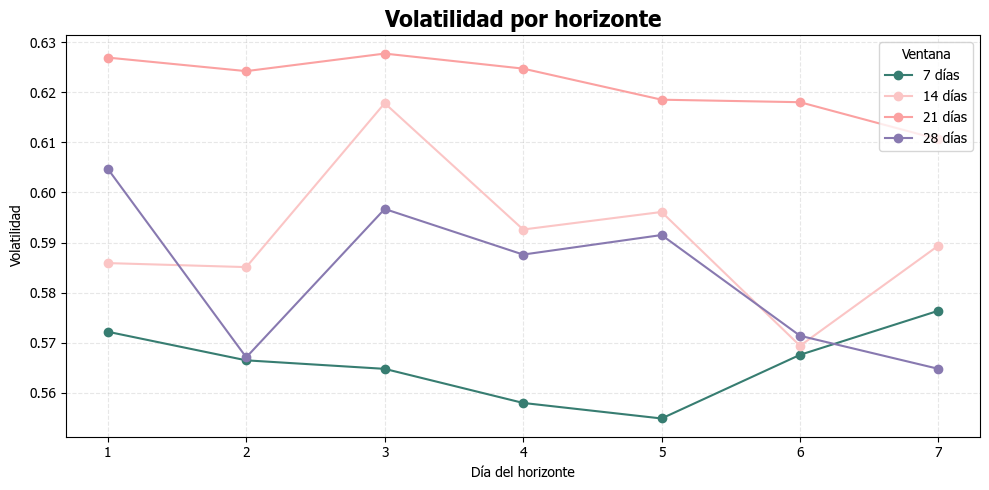

In [10]:
# [Gráfico] Predicción de volatilidad de cada horizonte por ventana

# Eliminar la fila 'avg' si no quieres graficarla
df_sin_avg = df.drop(index='avg')

# Convertir índice a entero para orden correcto
df_sin_avg.index = df_sin_avg.index.astype(int)

# Graficar
plt.figure(figsize=(10, 5))

for ventana in df_sin_avg.columns:
    color = colores_por_ventana.get(int(ventana))
    plt.plot(df_sin_avg.index, df_sin_avg[ventana], label=f'{ventana} días', marker='o', color = color)

plt.title(f'Volatilidad por horizonte')
plt.xlabel('Día del horizonte')
plt.ylabel('Volatilidad')
plt.xticks(df_sin_avg.index)
plt.legend(title='Ventana')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(f"figs/Predicted_{objetivo}_each_horizont_by_window.png", dpi=300, bbox_inches="tight")
plt.show()

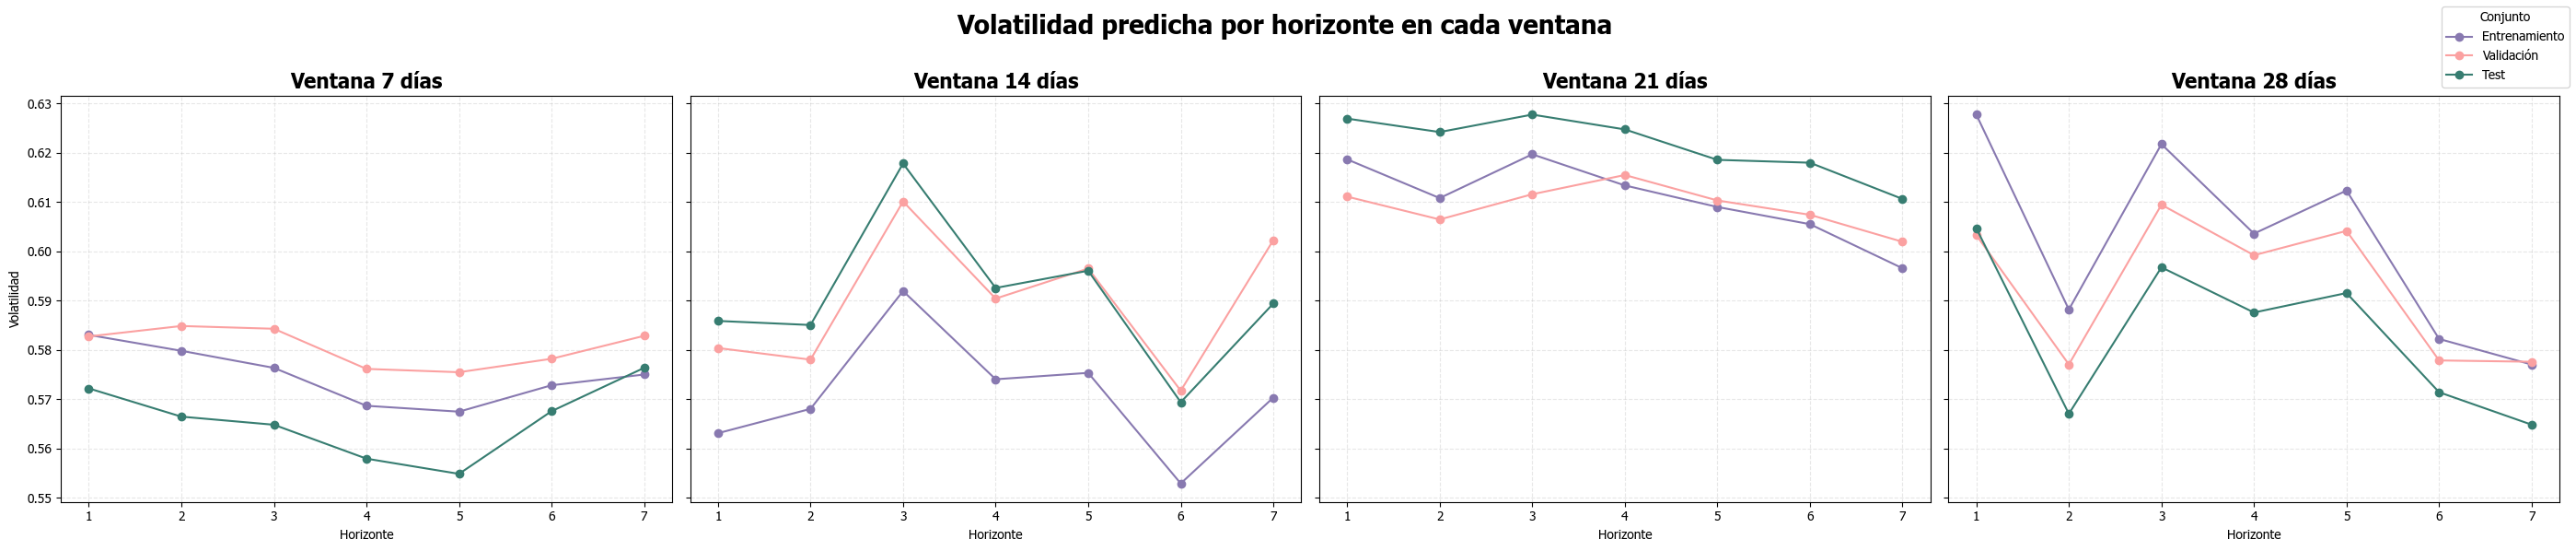

In [11]:
# [Gráfico] Predicción de volatilidad de cada horizonte por ventana por conjunto

num_WINDOW_SIZES = len(WINDOW_SIZES)
fig, axes = plt.subplots(nrows=1, ncols=num_WINDOW_SIZES, figsize=(7*len(WINDOW_SIZES), 6), sharey=True)

for i, ventana in enumerate(WINDOW_SIZES):
    
    folds = results[ventana]["folds"]
    num_outputs = folds[0]['yhat_test'].shape[1]

    # Inicializar acumuladores
    train_por_h = [[] for _ in range(num_outputs)]
    val_por_h = [[] for _ in range(num_outputs)]
    test_por_h = [[] for _ in range(num_outputs)]

    for fr in folds:
        for h in range(num_outputs):
            train_por_h[h].extend(fr['yhat_train'][:, h])
            val_por_h[h].extend(fr['yhat_val'][:, h])
            test_por_h[h].extend(fr['yhat_test'][:, h])

    # Calcular promedios
    train_avg = [np.mean(v) for v in train_por_h]
    val_avg = [np.mean(v) for v in val_por_h]
    test_avg = [np.mean(v) for v in test_por_h]

    horizonte = np.arange(1, num_outputs + 1)
    ax = axes[i]

    ax.plot(horizonte, train_avg, label='Entrenamiento', color='#8879B0', marker='o')
    ax.plot(horizonte, val_avg, label='Validación', color='#FBA1A1', marker='o')
    ax.plot(horizonte, test_avg, label='Test', color='#377D71', marker='o')

    ax.set_title(f'Ventana {ventana} días')
    ax.set_xlabel('Horizonte')
    if i == 0:
        ax.set_ylabel('Volatilidad')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xticks(horizonte)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Conjunto')
fig.suptitle('Volatilidad predicha por horizonte en cada ventana', fontsize=20, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/Predicted_{objetivo}_each_horizont_by_window_by_conjunto.png", dpi=300, bbox_inches="tight")
plt.show()

### Conjunto del split

C:\Users\Hp\AppData\Local\Temp\ipykernel_69188\3239545551.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=etiquetas, patch_artist=True,
C:\Users\Hp\AppData\Local\Temp\ipykernel_69188\3239545551.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=etiquetas, patch_artist=True,
C:\Users\Hp\AppData\Local\Temp\ipykernel_69188\3239545551.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=etiquetas, patch_artist=True,
C:\Users\Hp\AppData\Local\Temp\ipykernel_69188\3239545551.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot()

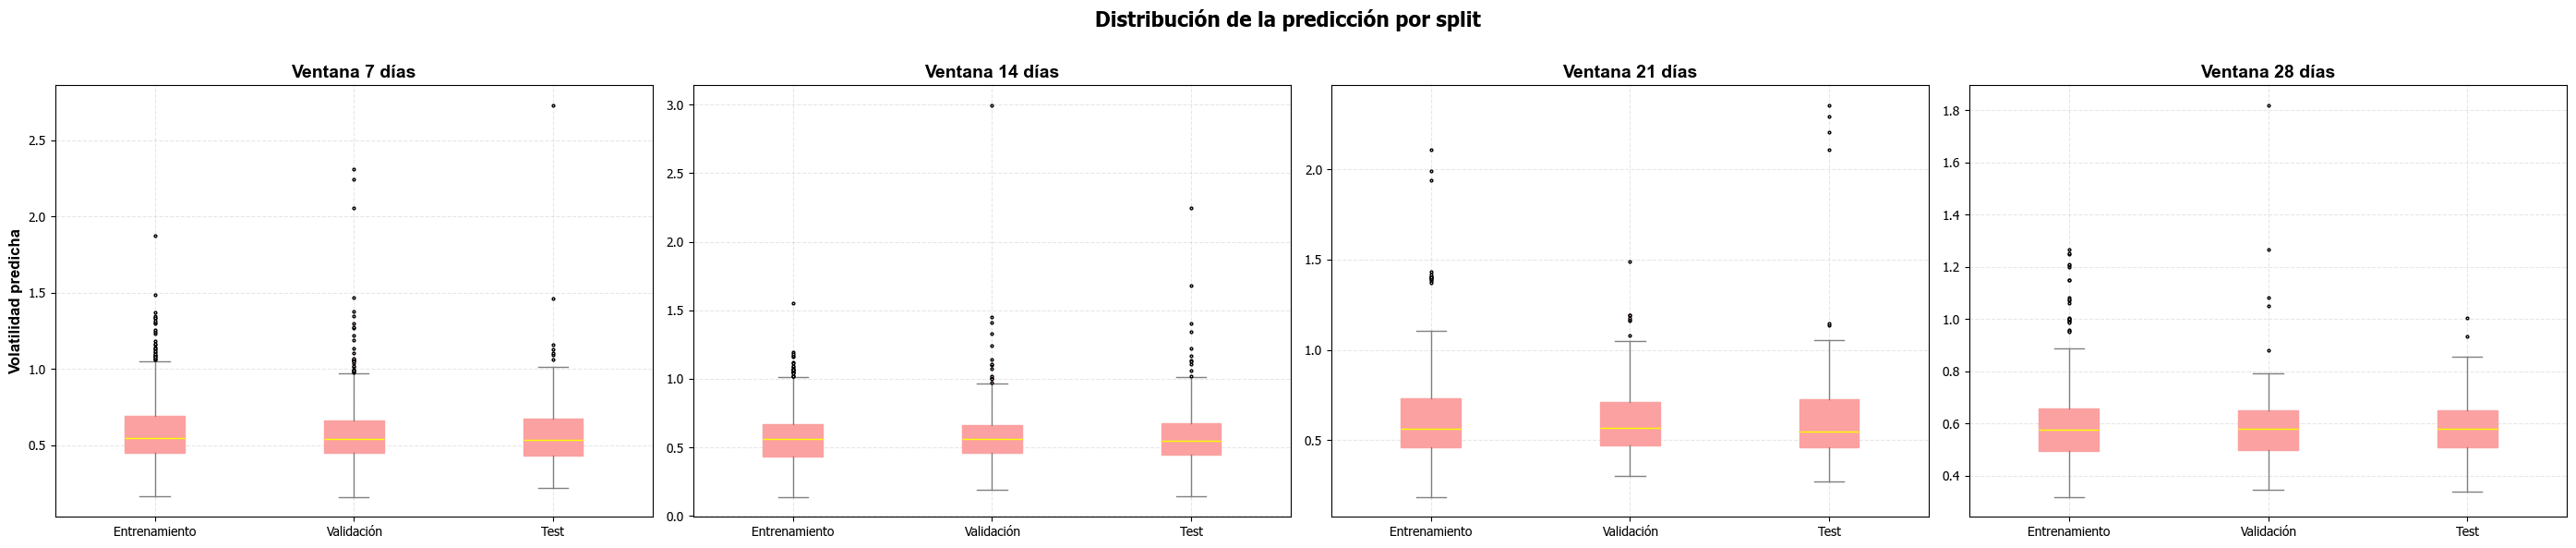

In [12]:
# [Gráfico] Volatilidad por ventana por split

fig, axes = plt.subplots(ncols=len(WINDOW_SIZES), nrows=1, figsize=(7 * len(WINDOW_SIZES), 6))

# Si solo hay una ventana, axes no es iterable
if len(WINDOW_SIZES) == 1:
    axes = [axes]

for i, ventana in enumerate(WINDOW_SIZES):
    folds = results[ventana]["folds"]

    # Acumuladores
    train_avg = []
    val_avg = []
    test_avg = []

    for fr in folds:
        train_avg.extend(np.mean(fr['yhat_train'], axis=1))
        val_avg.extend(np.mean(fr['yhat_val'], axis=1))
        test_avg.extend(np.mean(fr['yhat_test'], axis=1))

    # Preparar datos para boxplot
    data = [train_avg, val_avg, test_avg]
    etiquetas = ['Entrenamiento', 'Validación', 'Test']

    # Graficar en subplot correspondiente
    ax = axes[i]
    ax.boxplot(data, labels=etiquetas, patch_artist=True,
               boxprops=dict(facecolor='#FBA1A1', color='#FBA1A1'),
               medianprops=dict(color='yellow'),
               whiskerprops=dict(color='gray'),
               capprops=dict(color='gray'),
               flierprops=dict(marker='o', markerfacecolor='pink', markersize=2))

    ax.set_title(f'Ventana {ventana} días',
                 fontsize=14, fontweight='bold', fontname='Arial')
    if i == 0:
        ax.set_ylabel('Volatilidad predicha', fontsize=12, fontweight='bold', fontname='Arial')
    ax.grid(True, linestyle='--', alpha=0.3)
fig.suptitle('Distribución de la predicción por split', fontsize=16, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/Dist_{objetivo}_each_split_by_window.png", dpi=300, bbox_inches="tight")
plt.show()

```{note}
Para el último día de la predicción

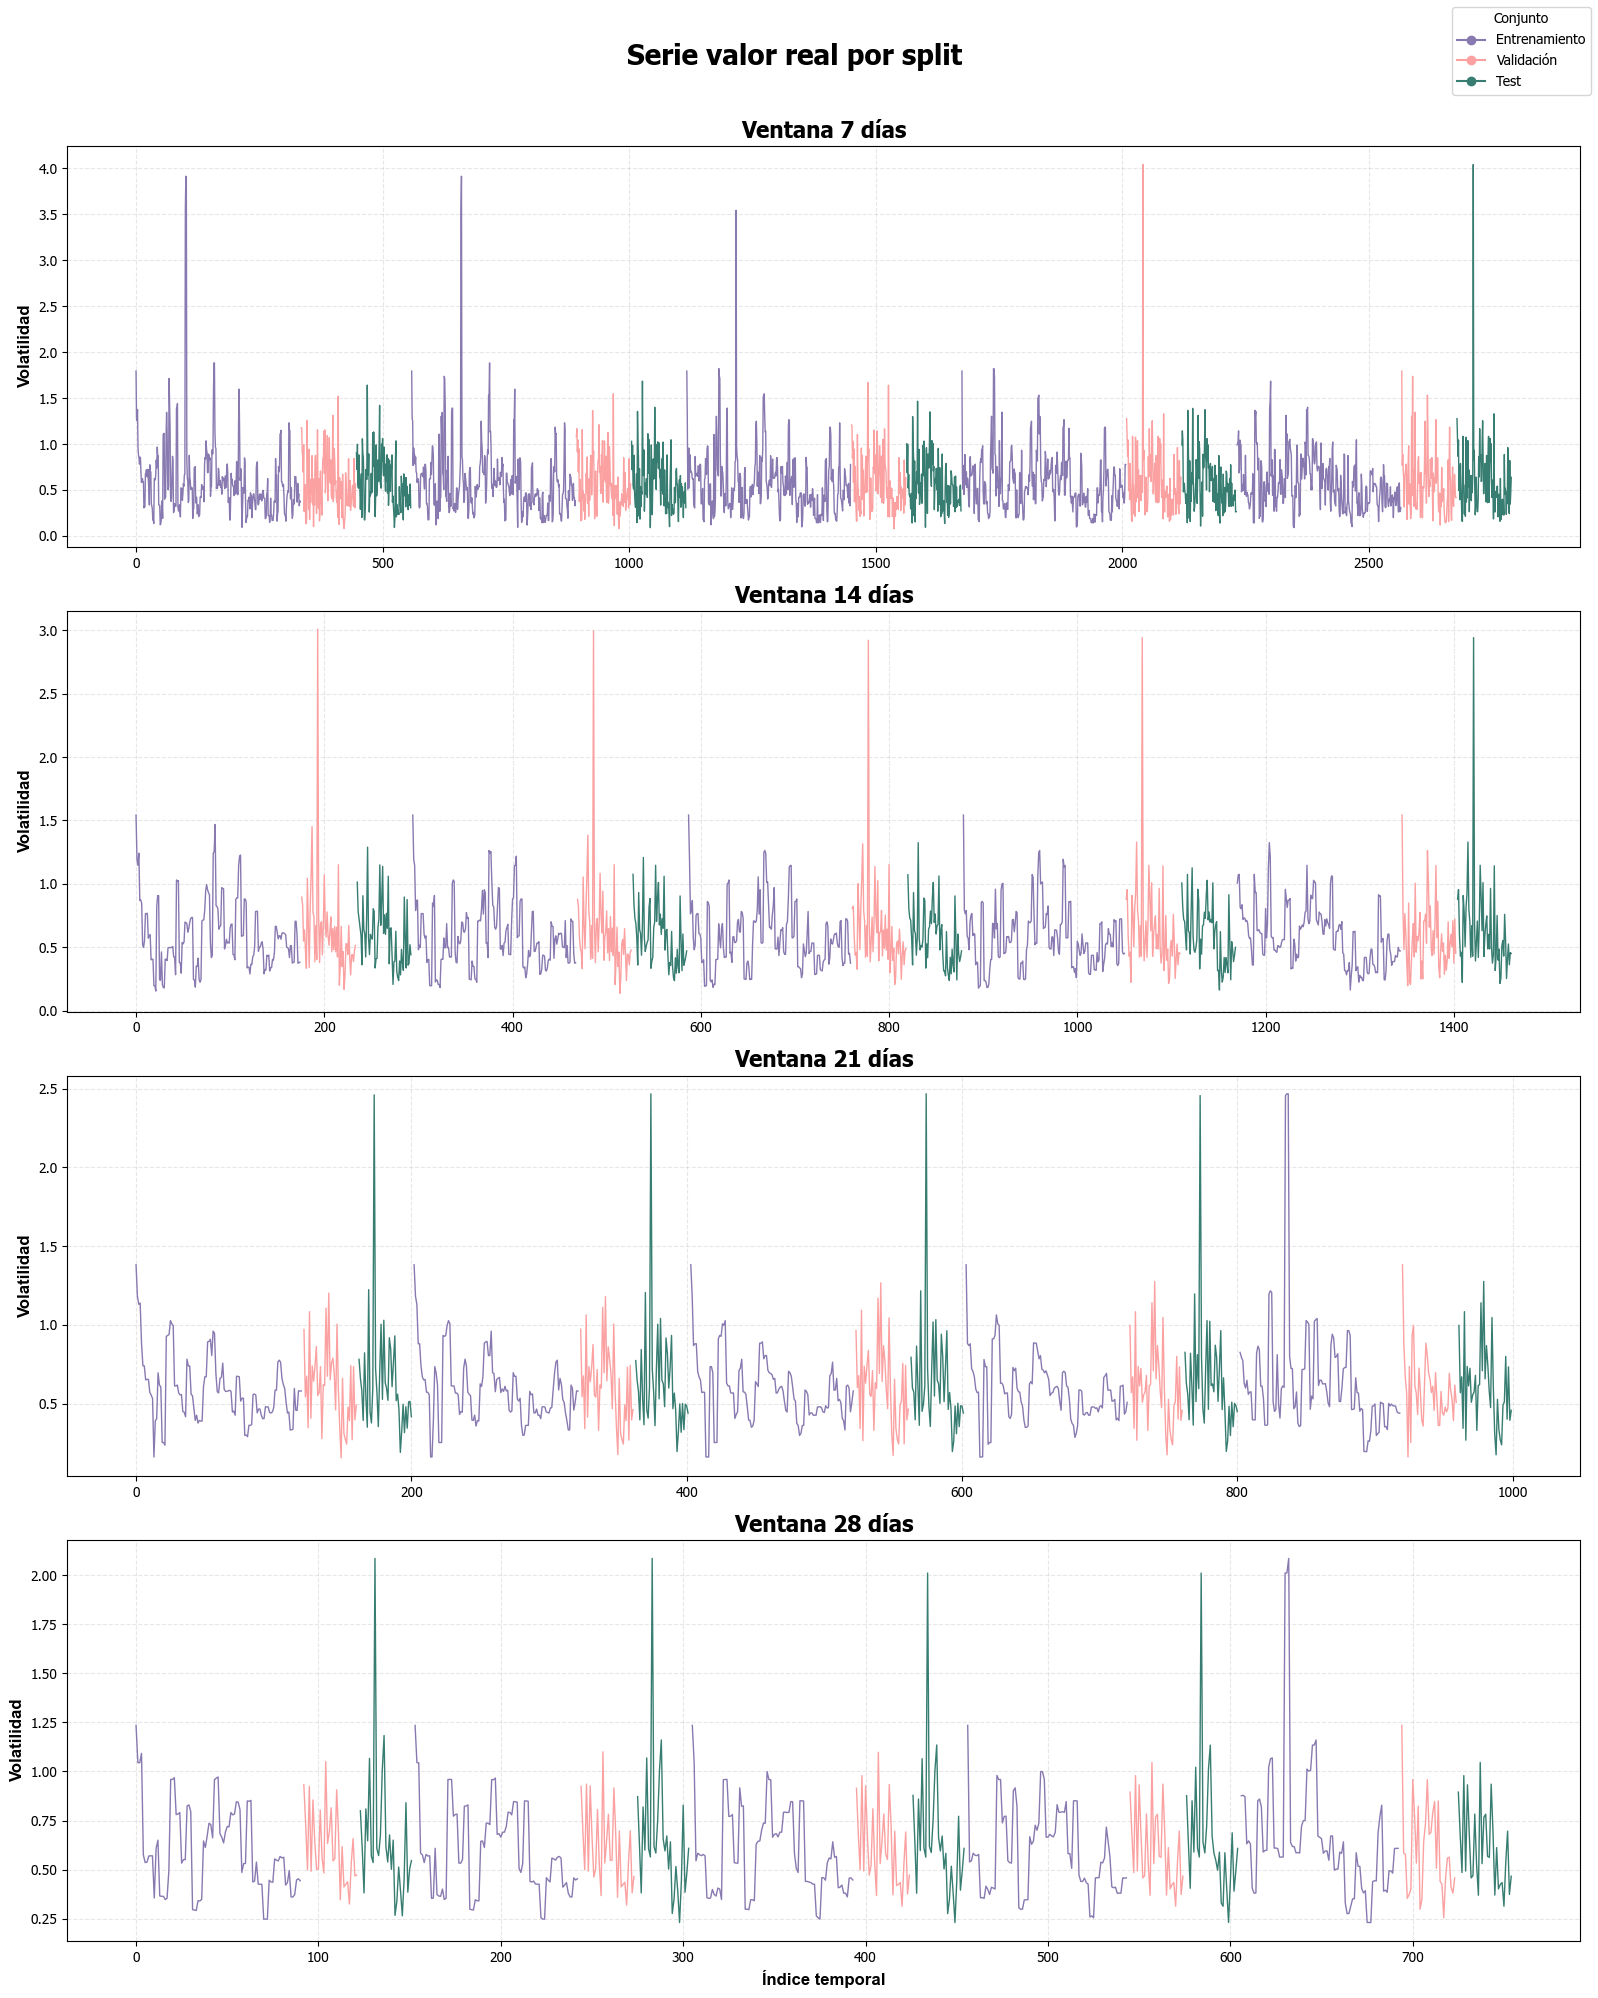

In [13]:
# [Gráfico] Serie de valor real por split

fig, axes = plt.subplots(nrows=len(WINDOW_SIZES), ncols=1, figsize=(16, 5 * len(WINDOW_SIZES)))

if len(WINDOW_SIZES) == 1:
    axes = [axes]

for i, ventana in enumerate(WINDOW_SIZES):
    folds = results[ventana]["folds"]
    ax = axes[i]
    idx = 0  # índice temporal global

    for j, fr in enumerate(folds):
        # Longitudes
        n_train = len(fr['y_train'])
        n_val = len(fr['y_val'])
        n_test = len(fr['y_test'])

        # Índices locales
        x_train = np.arange(idx, idx + n_train)
        x_val = np.arange(idx + n_train + 1, idx + n_train + 1 + n_val)
        x_test = np.arange(idx + n_train + 1 + n_val + 1, idx + n_train + 1 + n_val + 1 + n_test)

        # Graficar cada segmento por separado
        ax.plot(x_train, fr['y_train'][:,-1], color='#8879B0', label='Entrenamiento' if j == 0 else "", linewidth=1)
        ax.plot(x_val, fr['y_val'][:,-1], color='#FBA1A1', label='Validación' if j == 0 else "", linewidth=1)
        ax.plot(x_test, fr['y_test'][:,-1], color='#377D71', label='Test' if j == 0 else "", linewidth=1)

        # Actualizar índice global con espacio entre bloques
        idx = x_test[-1] + 2

    # Configuración del subplot
    ax.set_title(f'Ventana {ventana} días')
    if i == 3: 
        ax.set_xlabel('Índice temporal', fontsize=12, fontweight='bold', fontname='Arial')
    ax.set_ylabel('Volatilidad', fontsize=12, fontweight='bold', fontname='Arial')
    ax.grid(True, linestyle='--', alpha=0.3)

fig.legend(handles, labels, title='Conjunto')
fig.suptitle('Serie valor real por split', fontsize=20, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/Serie_Valor_real_por_split.png", dpi=300, bbox_inches="tight")
plt.show()

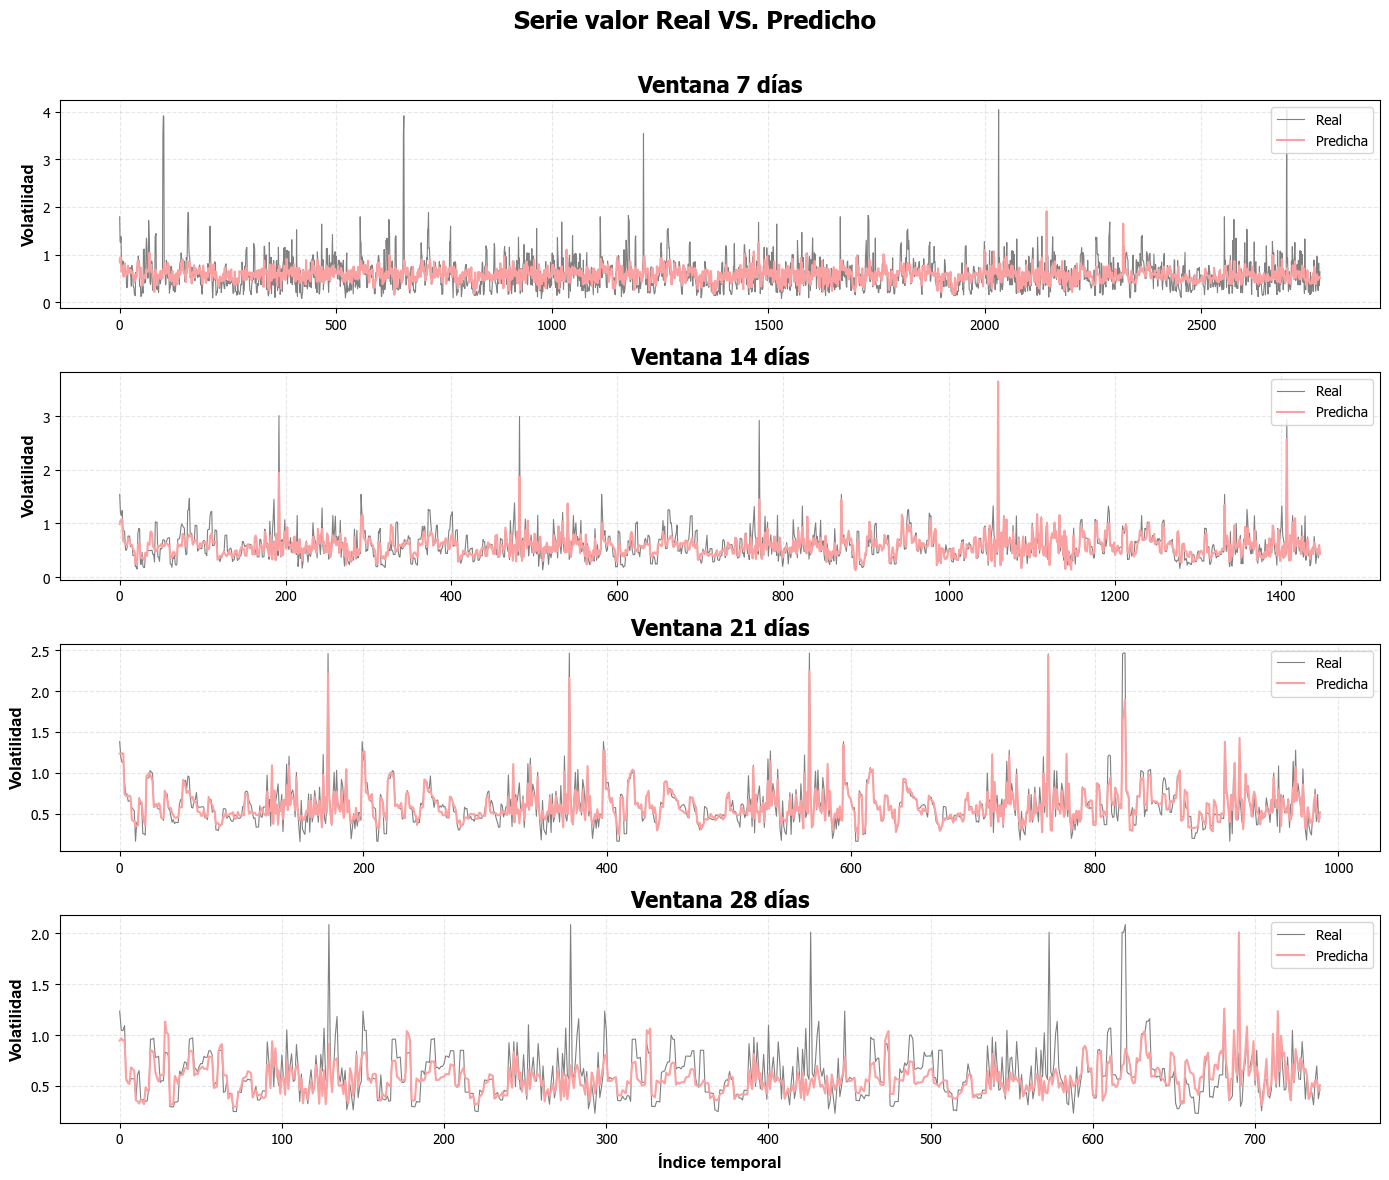

In [ ]:
# [Gráfica] Serie de Real VS. Predicha

# Crear figura con subplots en una sola columna
fig, axes = plt.subplots(nrows=len(WINDOW_SIZES), ncols=1, figsize=(14, 12))

# Asegurar que axes sea iterable
if len(WINDOW_SIZES) == 1:
    axes = [axes]

for i, ventana in enumerate(WINDOW_SIZES):
    folds = results[ventana]["folds"]
    serie_real = []
    serie_pred = []

    for fr in folds:
        serie_real.extend(fr["y_train"])
        serie_real.extend(fr["y_val"])
        serie_real.extend(fr["y_test"])
        
        serie_pred.extend(fr["yhat_train"])
        serie_pred.extend(fr["yhat_val"])
        serie_pred.extend(fr["yhat_test"])

    # Convertir a arrays
    serie_real = np.array(serie_real)
    serie_pred = np.array(serie_pred)

    # Graficar en subplot correspondiente
    ax = axes[i]
    ax.plot(serie_real[:, -1], linestyle='-', color='grey', linewidth=0.8, label='Real')
    ax.plot(serie_pred[:, -1], linestyle='-', color='#FBA1A1', label='Predicha')

    ax.set_title(f'Ventana {ventana} días')
    if i == 3:
        ax.set_xlabel('Índice temporal', fontsize=12, fontweight='bold', fontname='Arial')
    ax.set_ylabel('Volatilidad', fontsize=12, fontweight='bold', fontname='Arial')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.3)
fig.suptitle('Serie: valor Real VS. Predicho', fontsize=18, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.savefig(f"figs/Serie_Valor_real_vs_predicho.png", dpi=300, bbox_inches="tight")
plt.show()

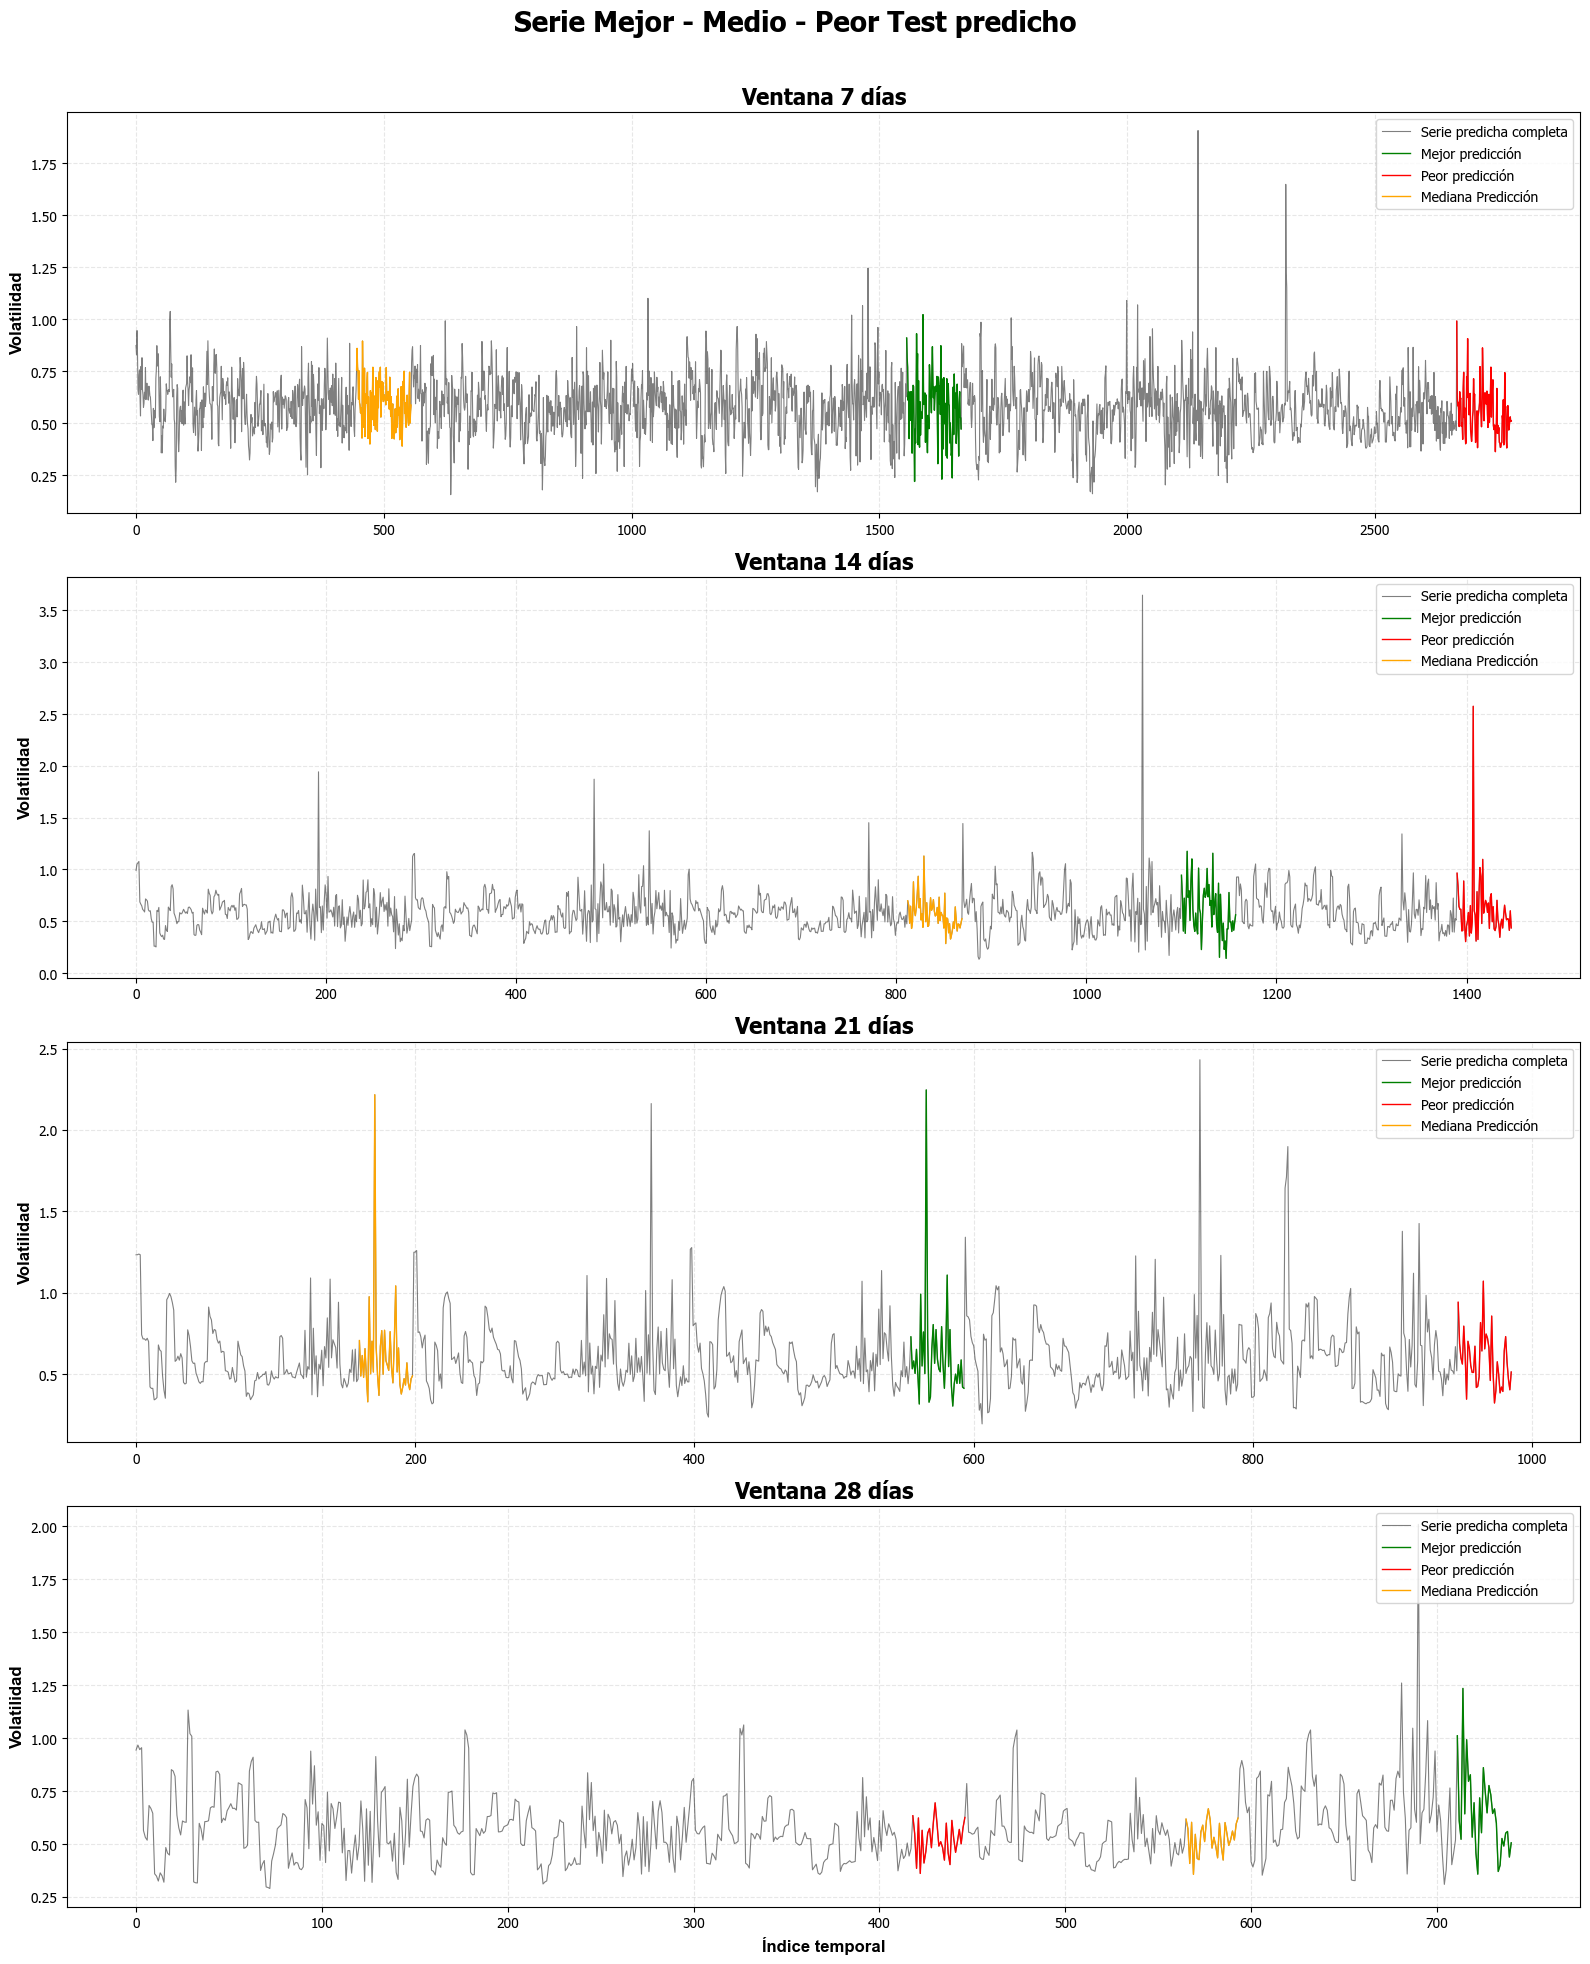

In [15]:
# [Gráfico] Mejor - Media - Peor fold de predicción

# Crear figura con subplots en una sola columna
fig, axes = plt.subplots(nrows=len(WINDOW_SIZES), ncols=1, figsize=(16, 5 * len(WINDOW_SIZES)))

# Asegurar que axes sea iterable
if len(WINDOW_SIZES) == 1:
    axes = [axes]

# Función auxiliar para calcular índice global del test
def obtener_indice_test(fold_obj, folds):
    idx = 0
    for fr in folds:
        n_train = len(fr['y_train'])
        n_val = len(fr['y_val'])
        n_test = len(fr['y_test'])
        if fr is fold_obj:
            return idx + n_train + n_val
        idx += n_train + n_val + n_test
    return None

# Iterar por ventana
for i, ventana in enumerate(WINDOW_SIZES):
    folds = results[ventana]["folds"]
    serie_pred = []

    for fr in folds:
        serie_pred.extend(fr["yhat_train"])
        serie_pred.extend(fr["yhat_val"])
        serie_pred.extend(fr["yhat_test"])

    serie_pred = np.array(serie_pred)

    # Obtener folds seleccionados
    best_fold = results[ventana]["best_fold"]
    worst_fold = results[ventana]["worst_fold"]
    medium_fold = results[ventana]["median_fold"]

    # Índices globales
    idx_best = obtener_indice_test(best_fold, folds)
    idx_worst = obtener_indice_test(worst_fold, folds)
    idx_medium = obtener_indice_test(medium_fold, folds)

    # Construir ejes
    x_best = np.arange(idx_best, idx_best + len(best_fold['yhat_test']))
    x_worst = np.arange(idx_worst, idx_worst + len(worst_fold['yhat_test']))
    x_medium = np.arange(idx_medium, idx_medium + len(medium_fold['yhat_test']))

    # Graficar en subplot correspondiente
    ax = axes[i]
    ax.plot(serie_pred[:, -1], linestyle='-', alpha=0.5, color='black', linewidth=0.8, label='Serie predicha completa')
    ax.plot(x_best, best_fold['yhat_test'][:, -1], label='Mejor predicción', color='green', linewidth=1)
    ax.plot(x_worst, worst_fold['yhat_test'][:, -1], label='Peor predicción', color='red', linewidth=1)
    ax.plot(x_medium, medium_fold['yhat_test'][:, -1], label='Mediana Predicción', color='orange', linewidth=1)

    ax.set_title(f'Ventana {ventana} días')
    if i == 3:
        ax.set_xlabel('Índice temporal', fontsize=12, fontweight='bold', fontname='Arial')
    ax.set_ylabel('Volatilidad', fontsize=12, fontweight='bold', fontname='Arial')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.3)

fig.suptitle('Serie Mejor - Medio - Peor Test predicho', fontsize=20, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/Serie_MMP_test_predicho.png", dpi=300, bbox_inches="tight")
plt.show()

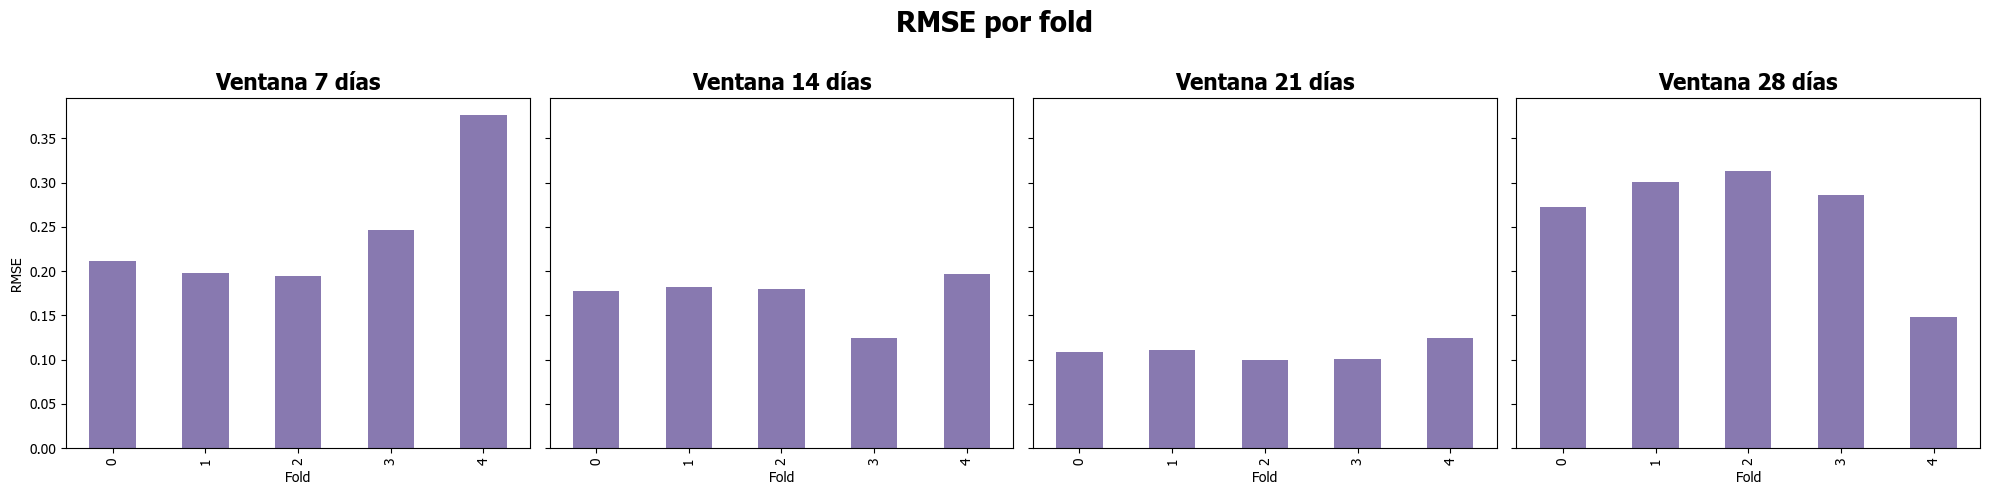

In [16]:
fig, axes = plt.subplots(1, len(WINDOW_SIZES), figsize=(5*len(WINDOW_SIZES), 5), sharey=True)

if len(WINDOW_SIZES) == 1:
    axes = [axes]

for i, window_size in enumerate(WINDOW_SIZES):
    df_metrics = results[window_size]["metrics"]

    # Filtrar solo horizonte "avg"
    RMSE_folds = df_metrics[df_metrics["Horizon"] == "avg"]
    RMSE_folds = RMSE_folds.set_index("fold")["RMSE"]

    # Graficar
    RMSE_folds.plot(kind="bar", ax=axes[i], color='#8879B0')
    axes[i].set_title(f"Ventana {window_size} días")
    axes[i].set_ylabel("RMSE" if i == 0 else "")
    axes[i].set_xlabel("Fold")

fig.suptitle(f"RMSE por fold", fontsize=20, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/{objetivo}_RMSE_promedio_folds.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\Hp\AppData\Local\Temp\ipykernel_69188\3127514217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics["Horizon"] = df_metrics["Horizon"].astype(int)
C:\Users\Hp\AppData\Local\Temp\ipykernel_69188\3127514217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics["Horizon"] = df_metrics["Horizon"].astype(int)
C:\Users\Hp\AppData\Local\Temp\ipykernel_69188\3127514217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

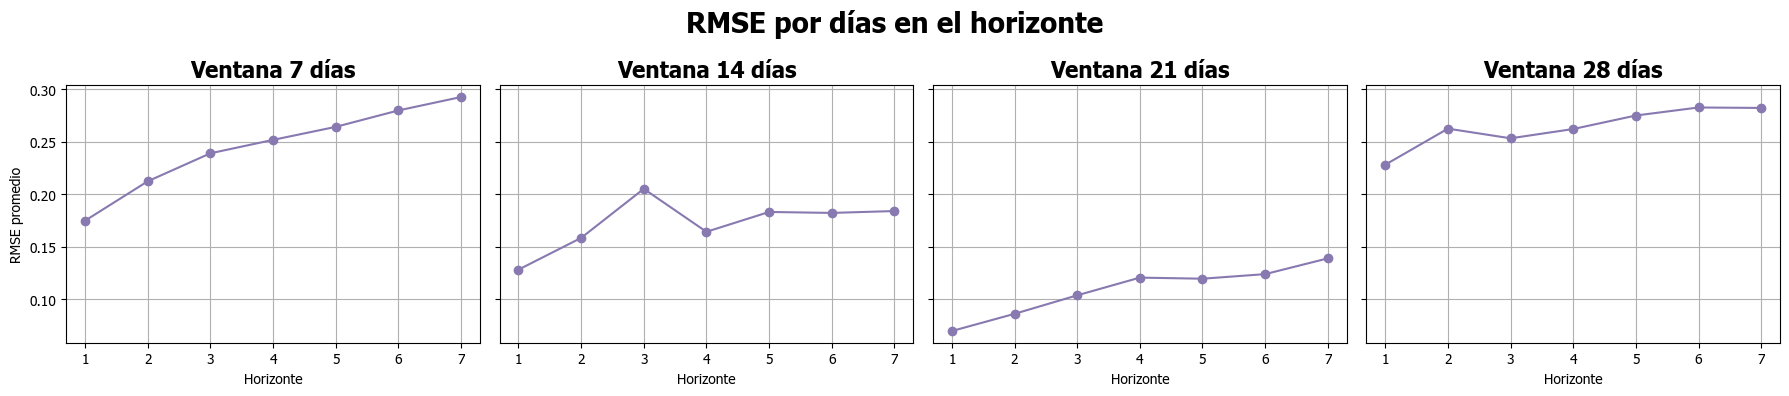

In [17]:
fig, axes = plt.subplots(1, len(WINDOW_SIZES), figsize=(18, 4), sharey=True)

for ax, window_size in zip(axes, WINDOW_SIZES):
    
    df_metrics = results[window_size]["metrics"]

    # Filtrar horizontes numéricos
    df_metrics = df_metrics[pd.to_numeric(df_metrics["Horizon"], errors="coerce").notna()]
    df_metrics["Horizon"] = df_metrics["Horizon"].astype(int)

    # Promedio por horizonte
    df_summary = (
        df_metrics.groupby("Horizon")["RMSE"]
        .mean()
        .reset_index()
    )

    # Graficar
    ax.plot(df_summary["Horizon"], df_summary["RMSE"], marker="o", color='#8879B0')
    ax.set_title(f"Ventana {window_size} días")
    ax.set_xlabel("Horizonte")
    ax.grid(True)

# Eje Y compartido
axes[0].set_ylabel("RMSE promedio")

fig.suptitle(f"RMSE por días en el horizonte", fontsize=20, fontweight='bold', fontname='Tahoma')
plt.tight_layout()
plt.savefig(f"figs/{objetivo}_RMSE_promedio_horizontes.png", dpi=300, bbox_inches="tight")
plt.show()
